# Computational Methods in Economics

## Lecture 5a - Numerical Optimization

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2020-01-08 09:17:36.703984


### Preliminaries

#### Import Modules

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.optimize

import statsmodels.api as sm

import IPython.display as display

## This Lecture

- [Introduction](#introduction)
- [Golden Search](#golden)
- [Overview: Line Search](#overview)
- [The Newton-Raphson Method](#newton)
- [Quasi-Newton Methods: BFGS](#quasi)
- [Example: Solving the NGM](#NGM)
- [Constrained Optimization](#constr)
- [Appendix](#Nelder-Mead)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'introduction'></a>

## Introduction

Optimization (minimization or maximization) is at the heart of almost all economic models, which makes numerical algorithms for optimization an essential part of an economist's computational toolbox. 

Before talking about these algorithms in detail, we start with a short refresher on the theory behind optimization.

#### Review: Unconstrained Optimization

Unconstrained optimization entails *minimizing* an (scalar) *objective function* $f: \mathbb{R}^n \rightarrow \mathbb{R}$:

\begin{equation}
    \min_{\mathbf{x}} f(\mathbf{x})
\end{equation}

with
\begin{equation}
    \mathbf{x} \in \mathbb{R}^n
\end{equation}
and $f$ being a smooth function.

Note that we frame the problem here in terms of minimization, mainly because that's how the Scipy implementations that we will see do it. *Maximizing* a function is equivalent to minimizing its negative.

Usually, we want to find a *global* minimum and hence a *global minimizer* of $f$. Formally, a global minimizer for the problem above is a point $\mathbf{x}^*$ if $f(\mathbf{x}^*) \le f(\mathbf{x})$ for all $\mathbf{x}$ in the relevant domain. 

However, most algorithms developed for numerical optimization (and in fact all algorithms discussed in this class) aim to find a local optimum, and hence a *local minimizer*. A local minimizer is a point $\mathbf{x}^*$ if there is a neighborhood $\mathcal{N}$ of $\mathbf{x}^*$ such that $f(\mathbf{x}^*) \le f(\mathbf{x})$ for all $\mathbf{x}$ in $\mathcal{N}$. 

For a *strict* or *strong* local minimizer, the inequality is strict. If $\mathbf{x}^*$ is the only local minimizer in $\mathcal{N}$, it is also called an *isolated* minimizer. All isolated local minimizers are strict, however strict minimizers are not always isolated.

Why do the methods below focus on local minimizers? The more points an algorithm has to "visit" (i.e. evaluate the function), the more computer time and/or storage it needs, which we aim to keep as small as possible. To find a global minimizer, we would need to sample points over the whole relevant domain of $f$. 

However, note if we know that a function is *convex*, a local minimizer is also a global minimizer. 

How do we recognize a local minimum? We rely on the following necessary and sufficient conditions (that you have probably used in almost every economics class you've ever taken):

- If $\mathbf{x}^*$ is a local minimizer and $\nabla^2 f$ exists and is continuous in an open neighborhood around $\mathbf{x}^*$, then the *gradient* is zero ($\nabla f(\mathbf{x}^*) = 0$) and $\nabla^2 f(\mathbf{x}^*)$ is positive semidefinite. For a univariate function, $f'(x^*) = 0$ and $f''(x^*) \ge 0$.
- Suppose that $\nabla^2 f$ is continuous in an open neighborhood around $\mathbf{x}^*$ and that $\nabla f(\mathbf{x}^*) = 0$ and $\nabla^2 f(\mathbf{x}^*)$ is positive definite. Then $\mathbf{x}^*$ is a strict local minimizer of $f$.

Recall that a square matrix $A$ of order $n$ is *positive definite* if there is a positive scalar such that

\begin{equation}
    \mathbf{x}^T A \mathbf{x} \ge \alpha \mathbf{x}^T \mathbf{x} \quad \text{for all} \quad \mathbf{x} \in \mathbb{R}^n
\end{equation}

It is *positive semidefinite* if 

\begin{equation}
    \mathbf{x}^T A \mathbf{x} \ge 0 \quad\text{for all} \quad \mathbf{x} \in \mathbb{R}^n
\end{equation}

Any positive definite matrix is also positive semidefinite (but not vice versa). For a univariate function, a positive semidefinite Hessian just means that the second derivative of the function is non-negative. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'golden'></a>

### Golden Search

Similar to root finding, for performing numerical optimization we have both derivative-free methods as well as algorithms that either rely on analytical derivatives provided by the user or approximate the derivatives numerically. 

First, we look at an important method for maximizing a *univariate* function without using derivates, namely *golden (section) search*.

Conceptually, golden search is similar to bisection: we bracket the minimum $x^*$ by the interval $[a, b]$ and then sequentially reduce the length of the interval. 

One important difference to bisection is that we need to evaluate the function at *two* points inside the bracket, rather than one as in the case of bisection.  

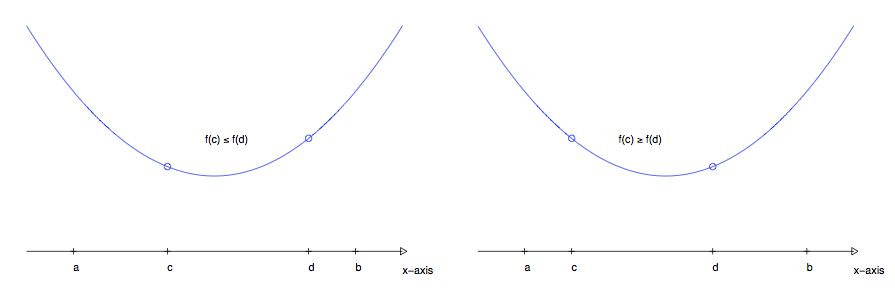

In [3]:
display.Image('gs.png')

The obvious question is then how to choose the *search points* $c$ and $d$ inside the bracket. Golden search prescribes the following rule:

\begin{align}
    c &= a + r (b - a) \\
    d &= b - r (b - a)
\end{align}

where

\begin{equation}
    r = \frac{3 - \sqrt{5}}{2} \approx 0.382...
\end{equation}    

This satisfies two criteria:

- The new interval always has the same length, independent on whether the upper or lower bound is replaced:

\begin{equation}
       b - c = d - a = (1 - r)(b - a) 
\end{equation}   

- For every refinement after the first, one of the search points equals the search point from the previous refinement that was not used as a new bound; in other words,

    1. if $f(c) < f(d)$, the new interval is $[a, d]$; for the next refinement, $d' = c$
    2. if $f(c) > f(d)$, the new interval is $[c, b]$; for the next refinement, $c' = d$

This has the advantage that only one function evaluation is performed per iteration; e.g. in the first case, we need to evaluate $f(c')$, but we already have evaluated $f(d') = f(c)$ for the previous refinement. 

In Python, golden section search for minimizing a univariate function is implemented in **scipy.optimize.golden**. It takes the function and a bracket as inputs. Below, we apply it on the function $f(x) = - \exp(-x) \sin(x)$.

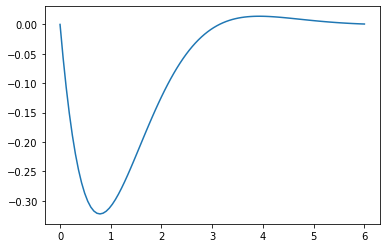

In [4]:
f = lambda x: -np.exp(-x) * np.sin(x)
x = np.linspace(0, 6, 100)
plt.plot(x, f(x))

In [5]:
scipy.optimize.golden(f, brack = (0, 2))

0.7853981651501754

We will not use golden search very often, for the simple reason that we usually optimize over functions with more than one variable. However, golden search is useful in the case of univariate functions with derivatives that are irregular or computationally costly to evaluate.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'overview'></a>

### Overview: Line Search

*Line search methods* are one of the two fundamental approaches to (unconstrained) optimization (*trust region methods* being the other), and the one which we focus on in this course. 

Line search is an iterative procedure, generating a sequence of iterates $\{ \mathbf{x}^{(k)} \}$ that are aimed to converge towards the minimum $\mathbf{x}^*$. 

When moving from one iterate to the next, two variables are essential: the *search direction*, denoted by $\mathbf{d}^{(k)}$, i.e. the direction in which to move from $\mathbf{x}^{(k)}$, and the *distance* $\alpha^{(k)}$, i.e. the length of the *step* $\mathbf{s}^{(k)}$ from $\mathbf{x}^{(k)}$ to $\mathbf{x}^{(k+1)}$ along $\mathbf{d}^{(k)}$.

On a general level, line search algorithms take the direction $\mathbf{d}^{(k)}$ as given and then solve the following problem:

\begin{equation}
    \min_{\alpha > 0} f(\mathbf{x}^{(k)} + \alpha \mathbf{d}^{(k)})
\end{equation}

and then set 

\begin{equation}
    \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \mathbf{s}^{(k)} = \mathbf{x}^{(k)} + \alpha^{(k)} \mathbf{d}^{(k)}
\end{equation}

Different variants of line search methods differ among each other in their choice of the search direction $\mathbf{d}^{(k)}$ and in how to determine the step size $\alpha$, as we will see below. As a result, they feature different steps $\mathbf{s}^{(k)} = \alpha^{(k)} \mathbf{d}^{(k)}$. 

Other than this, they all follow the same (by now well-known) iterative procedure that is implemented in the function **my_opt**.

In [6]:
def my_opt(x, obj, step, maxit = 100, tol = 1e-8):
    """
    Implements the iterative procedure for all of the optimization algorithms considered below. 
    Mandatory inputs are 
    -> x: initial guess for the minimizing vector
    -> obj: objective, defined a function of x
    -> step: a function implementing how the step from x(k) to x(k+1) is determined
    """
    dist = 1
    it = 0
    
    lx = []
    while dist > tol and it < maxit:
        lx.append(x)
        it += 1
    
        s, alpha = step(x, obj)
    
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(x))
        print(it, dist, alpha)
        x = x + s
    
    return x, lx           

Note the following:

- **my_opt** takes an "update rule" (a function) **step** as an argument, which returns $\mathbf{s}^{(k)}$, as well as $\alpha^{(k)}$. The implementation of **step** depends on the specific algorithm, as outlined below.

- For illustration, we print the iteration counter, the distance and the value for $\alpha^{(k)}$ in every iteration. We also store the values for $\mathbf{x}^{(k)}$ in a list **lx**. 

- As with rootfinding, our stopping rule checks for convergence, i.e. the update step $\mathbf{s}^{(k)} $ should be sufficiently small. More precisely, We use the relative distance between the current and the updated $\mathbf{x}$  as a stopping criterion, which can be written as

\begin{equation}
    \frac{ || \mathbf{s}^{(k)} || }{1 + || \mathbf{x}^{(k)} ||} \le tol
\end{equation}

As before, a good rule of thumb for the value of $tol$ is the square root of machine epsilon.  

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'newton'></a>

### Newton-Raphson

Recall that in the context of root finding in the previous lecture, Newton's method used an iteration rule based on taking a first-order Taylor approximation of the function of interest and setting it to zero. 

Similarly, Newton's method in the context of optimization, also called the *Newton-Raphson method*, requires a second-order Taylor approximation to $f$, which is then minimized. 

For a multivariate function $f: \mathbb{R}^n\ \rightarrow \mathbb{R}$, a second-order Taylor approximation of $f(\mathbf{x})$ around $x_0$ is given by:

\begin{equation}
    f(\mathbf{x}) \approx f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0)^{T} (\mathbf{x} - \mathbf{x}_0) + \frac{1}{2} (\mathbf{x} - \mathbf{x}_0)^T \nabla^2 f(\mathbf{x}_0) (\mathbf{x} - \mathbf{x}_0)
\end{equation}

Minimizing $f$ implies taking the derivative with respect to $\mathbf{x}$ and setting it equal to zero:

\begin{equation}
    \nabla f(\mathbf{x}) \approx \nabla f(\mathbf{x}_0) + \nabla^2 f(\mathbf{x}_0) (\mathbf{x} - \mathbf{x}_0) = 0
\end{equation}

As in the case of root finding, we can derive an iteration rule by rearranging:

\begin{equation}
 \mathbf{x} = \mathbf{x}_0 - [\nabla^2 f(\mathbf{x}_0)]^{-1} \nabla f(\mathbf{x}_0)
\end{equation}

For notational convenience, I define $H(\mathbf{x}_0) = \nabla^2 f(\mathbf{x}_0)$ for the Hessian. For the following,  we implicitly assume here that $H(\cdot)$ is positive semidefinite (recall the necessary conditions for a minimum above). We will get back to this later. 

Hence, the key idea is to use this relation iteratively, i.e. generate a sequence $\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, ..., \mathbf{x}^{(m)}$ where

\begin{equation}
 \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - H(\mathbf{x}^{(k)}) ^{-1}\nabla  f(\mathbf{x}^{(k)}) = \mathbf{x}^{(k)} + \mathbf{s}^{(k)}
\end{equation}

Recall that in the context of root finding, Newton's method relies on successive linearization, i.e. generates a sequence of points, each of which is a root to a linear local approximation to the function of interest. 

Similarly, at each iteration Newton-Raphson replaces the function $f$ with a *quadratic* local approximation based on $\mathbf{x}^{(k)}$ and chooses the minimum of this approximation as the next point $\mathbf{x}^{(k+1)}$.

The Newton-Raphson method implements the following pseudo-code:

(i) Choose an initial guess $\mathbf{x}^{(0)}$ and tolerance levels/stopping criteria $\epsilon$ and $\delta$. 

(ii) Compute the gradient $\nabla  f(\mathbf{x}^{(k)})$ and the Hessian $H(\mathbf{x}^{(k)})$ at $\mathbf{x}^{(k)}$ (using either analytical derivatives or numerical differentiation).

(iii) Solve $H(\mathbf{x}^{(k)})s^{(k)} = - \nabla f(\mathbf{x}^{(k)})$, and set $ \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \mathbf{s}^{(k)} $.

(iv) Check the stopping rule: if $\left| \left |\ \mathbf{x}^{(k+1)}- \mathbf{x}^{(k)} \right| \right| < \epsilon\left(1 + \left| \left |\ \mathbf{x}^{(k)} \right| \right|\right)$, stop. If not, go back to (ii).

(v) Check for optimality: if $\left| \left| \nabla f( \mathbf{x}^{(k)}) \right| \right| < \delta \left(1 + \left|\ f(\mathbf{x}^{(k)}) \right| \right)$, report $\mathbf{x}^{(k)}$ as the solution. Otherwise, report failure.

In the context of root finding, we stated that Newton's method converges *quadratically*. The same is true for the Newton-Raphson method, as long as we are sufficiently close to the solution. This is summarized in the following theorem: 

Suppose that $f(\mathbf{x})$ is thrice continuously differentiable, minimized at $\mathbf{x}^*$ and that $H(\mathbf{x}^*)$ is non-singular. Then there is some $\xi > 0$ such that if $\left| \left|\ \mathbf{x}^{(0)} - \mathbf{x}^* \right| \right| < \xi$, then the sequence $\{ \mathbf{x}^{(k)} \}$ converges quadratically to $\mathbf{x}^*$.

#### Example 1: Rosenbrock Function

As a first example, we apply the Newton-Raphson to the Rosenbrock function described in the appendix. The Rosenbrock function is often used to test the performance of optimization algorithms.

What makes it very convenient for us is that Scipy has an implementation of the Rosenbrock function, as well as of its (analytical) gradient and Hessian, as **scipy.optimize.rosen**, **scipy.optimize.rosen_der** and **scipy.optimize.rosen_hess**, respectively. Hence, we do not need to code the gradient and the Hessian ourselves.

Recall that in order to run Newton-Raphson using our **my_opt** function defined above, we just have to provide a rule on how the step $\mathbf{s}^{(k)}$ from $\mathbf{x}^{(k)}$ to  $\mathbf{x}^{(k+1)}$ is computed. This is implemented by the function **newton_rb**. 

In [7]:
def newton_rb(x, obj):
    """
    Implements the Newton-Raphson update rule for the Rosenbrock function
    """
    gr = scipy.optimize.rosen_der(x)
    H = scipy.optimize.rosen_hess(x)
    
    return ( scipy.linalg.solve(H, -gr), 1)

We then use this update rule as an input into **my_opt** to solve for the minimum, together with a starting value for $\mathbf{x}$ and the objective function (**scipy.optimize.rosen**). 

As you can see in the appendix, for $N = 5$, the derivative-free Nelder-Mead simplex algorithm required about 400 iterations to get to a solution. As demonstrated here, unsurprisingly, Newton-Raphson is consideraby faster.

In [8]:
x0 = np.array([1.5, 2, 2, 2, 2])
x, lx = my_opt(x0, scipy.optimize.rosen, newton_rb)
print("Solution: {}".format(x))

1 0.48215462558968025 1
2 0.3529605284563699 1
3 0.01673833448865884 1
4 0.8642662420786184 1
5 0.5963570709514205 1
6 0.09377391130156572 1
7 0.012188351825798683 1
8 0.04001688973515537 1
9 0.0012258577284614402 1
10 0.0009498483479981958 1
11 5.465093809902131e-07 1
12 2.612421187504453e-10 1
Solution: [1. 1. 1. 1. 1.]


To illustrate quadratic convergence, compare the distance from $\mathbf{x}^{(k)}$ to $\mathbf{x}^*$:

In [9]:
np.set_printoptions(suppress=True)
print(x - lx)

[[-0.5        -1.         -1.         -1.         -1.        ]
 [-0.27262541 -0.53088921 -0.6465265  -1.11499121 -3.45996486]
 [-0.16156446 -0.32979267 -0.63509542 -1.64301221 -5.70670738]
 [-0.12938432 -0.27449176 -0.61676858 -1.61377184 -5.83094825]
 [-0.05204137 -0.10096984 -0.18145453 -0.20667585  1.52385252]
 [-0.02691766 -0.05391759 -0.10745702 -0.20913927 -0.46201171]
 [-0.01080689 -0.02151356 -0.04246116 -0.08168551 -0.15379908]
 [-0.00726082 -0.01459695 -0.02944082 -0.05969631 -0.12247275]
 [-0.00064894 -0.00125795 -0.00234786 -0.00398128 -0.00487425]
 [-0.00016622 -0.00033305 -0.00066728 -0.00133525 -0.00266528]
 [-0.00000025 -0.00000048 -0.00000085 -0.00000126 -0.00000073]
 [-0.         -0.         -0.         -0.         -0.        ]]


In this example, we have used implementations of the analytical gradient and Hessian of the Rosenbrock function which are provided by Scipy. For other examples, we would have to compute these manually, which can be time-consuming. 
 
As an alternative, we could use approximations to gradient and Hessian by using numerical differentiation, as seen in the last lecture. The **statsmodel** package has an implementation of the numerical Hessian (**sm.tools.numdiff.approx_hess3**).

The function **newton** implements the Newton-Raphson update rule using these numerical derivatives. Note that we can use **newton** for any objective function (unlike **newton_rb**, which applies only to the Rosenbrock function). 

In [10]:
def newton(x, obj):
    """
    Implements the Newton-Raphson update rule, using numerical differentiation
    """
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    H = sm.tools.numdiff.approx_hess3(x, obj)
    
    return ( scipy.linalg.solve(H, -gr), 1 )

We can then use **newton** to solve again for the minimum of the Rosenbrock function, and compare the results to the implementation above with the analytical gradient and Hessian. 

As we can see when printing the norm of the update steps, it takes the same number of iterations and there only very small deviations between the two approaches.

In [11]:
x0 = np.array([1.5, 2, 2, 2, 2])
x, lx = my_opt(x0, scipy.optimize.rosen, newton)
print("Solution: {}".format(x))

1 0.4821545594562625 1
2 0.35295778184895965 1
3 0.01673703857131998 1
4 0.8642556870441718 1
5 0.5963426612270167 1
6 0.09378734792919464 1
7 0.012184475364110117 1
8 0.04002163405477126 1
9 0.0012249595287598752 1
10 0.0009496185377171005 1
11 5.410677220220418e-07 1
12 2.538059793831859e-10 1
Solution: [0.9999992  0.99999841 0.99999684 0.99999368 0.99998736]


#### Example 2: Monopoly

This example is taken from Judd (1998), p. 105 f. Suppose a firm produces two products, $Y$ and $Z$. The demand for them can be derived from the household's utility function

\begin{equation}
U(Y, Z) = u(Y, Z) + M = (Y^\alpha + Z^\alpha)^{\frac{\eta}{\alpha}} + M,
\end{equation}

where $M$ denotes expenditures on other goods. Solving the household problem, we get $p_j = u_j(Y, Z)$ (verify this!). 

If the firm acts a monopolist, it takes into account how prices depend on the supply of $Y$ and $Z$. Hence, its profit maximization problem can be written as:

\begin{equation}
    \max_{Y, Z} \Pi(Y, Z) = u_Y(Y, Z) Y + u_Z(Y, Z) Z - c_Y Y - c_Z Z,
\end{equation}

where we assume that the marginal cost of producing $Y$ and $Z$ are constant and given by $c_Y$ and $c_Z$, respectively.

The following piece of code determines the parameter values and defines the cost and utility functions, including a function computing the derivatives of $u$.

In [12]:
### functions and parameters
alpha = 0.98
eta = 0.85

cy = 0.62
cz = 0.6

Cy = lambda x : cy * x
Cz = lambda x : cz * x

In [13]:
def u(Y, Z):
    """
    Returns the u function.
    """
    return (Y**alpha + Z**alpha)**(eta/alpha)

def ud(Y, Z):
    """
    Returns the derivative of the u function.
    """
    return eta * (Y**alpha + Z**alpha)**(eta/alpha - 1) * Y**(alpha - 1)

One issue when using unconstrained optimization for economic problems is that many variables are bound to be nonnegative. In the example here, $Y$ and $Z$ represent quantities of goods, and hence, by definition, cannot be negative. 

However, the algorithms presented below may "visit" negative values for these decision variables. A common "trick" to deal with this is to restate the problem in terms of $\ln(Y) \equiv y$ and $\ln(Z) \equiv z$. In this way, while $y$ and $z$ can take any values, $Y = \exp(y)$ and $Z = \exp(z)$ are guaranteed to be positive.

Hence, the objective function can be coded up in the following way:

In [14]:
def obj(x):
    """
    Implements the objective function (here profit) for the monopoly example: Y * ud(Y, Z) + Z * ud(Z, Y) - Cy(Y) - Cz(Z)
    """
    Y = np.exp(x[0])
    Z = np.exp(x[1])
    
    return - (Y * ud(Y, Z) + Z * ud(Z, Y) - Cy(Y) - Cz(Z))

When solving the model, to save on coding effort, we again use the numerical approximations to the gradient and Hessian provided by statsmodels' **tools.numdiff** package, implicitly hoping that the approximation error is small.

Hence, we can use the **newton** function above as update rule in **my_opt**. The objective function is given by **obj** defined above. Recall that in this example, we optimize over the logarithm of our choice variables, and hence we need to apply the exponential function to get our equilibrium quantities. 

In [15]:
x0 = np.array([1.5, 2])
x, lx = my_opt(x0, obj, newton)
## print equilibrium -> recall that the model is solved for log quantities!
print("Equilibrium quantities: {}".format(np.exp(x)))

1 0.2355333601218139 1
2 0.22377718040760183 1
3 0.17710060685084983 1
4 0.17469787396275177 1
5 0.09928293978403069 1
6 0.03172929214226067 1
7 0.0030980276679803713 1
8 3.0283750218728924e-05 1
9 0.0 1
Equilibrium quantities: [0.56975348 2.93569797]


#### Second convergence test

Consider a modification of **my_opt**. As with rootfinding, we can use a "twofold" convergence test: first we determine if the sequence has converged, and then we check whether we have achieved optimality (i.e. whether $\nabla f( \mathbf{x}^{(k)})$ is close to zero). 

More precisely, the optimality test checks whether $\left| \left |\ \nabla f( \mathbf{x}^{(k)}) \right| \right| < \delta\left(1 + \left|\ f(\mathbf{x}^{(k)}) \right|\right)$. This test is typically passed for most objective functions that we encounter and hence "optional". Below, we again use a numerical approximation to the gradient. In this case, $\delta$ should not be set too low.

In [16]:
def my_opt(x, obj, step, maxit = 100, tol = 1e-8, delta = 1e-4):
    """
    Implements the iterative procedure for all of the optimization algorithms considered below. 
    Mandatory inputs are 
    -> x: initial guess for the minimizing vector
    -> obj: objective, defined a function of x
    -> step: a function implementing how the step from x(k) to x(k+1) is determined
    """
    dist = 1
    it = 0
    
    lx = []
    while dist > tol and it < maxit:
        lx.append(x)
        it += 1
    
        s, alpha = step(x, obj)
    
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(x))
        print(it, dist, alpha)
        x = x + s
    
    ## check for optimality
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    if np.linalg.norm(gr) > delta * (1 + abs(obj(x))):
        print('Solution does not appear an optimum!')
    
    return x, lx           

#### Newton-Raphson with Line Search

Note that the Newton-Raphson algorithm is a special case of line search methods, where the step size $\alpha$ is fixed at 1, and the search direction is given by 

\begin{equation}
  \mathbf{d}^{(k)} = \mathbf{s}^{(k)} = - H(\mathbf{x}^{(k)}) ^{-1}\nabla  f(\mathbf{x}^{(k)})
\end{equation}


A variant of the Newton-Raphson method adjusts $\alpha$ (Newton-Raphson with line search). Recall from above that the idea of line search methods was to find $\alpha^*$ that minimizes the function value for a given search direction $\mathbf{d}^{(k)}$:

\begin{equation}
    \min_{\alpha > 0} \phi(\alpha) = f(\mathbf{x}^{(k)} + \alpha \mathbf{d}^{(k)})
\end{equation}

and then set 

\begin{equation}
    \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \mathbf{s}^{(k)} = \mathbf{x}^{(k)} + \alpha^* \mathbf{d}^{(k)}
\end{equation}

This is a minimization problem in one dimension: $\phi$ is a univariate function in $\alpha$. Hence, we could use an algorithm to minimize a univariate function, e.g. golden search. 

The following piece of code modifies the **newton** function above by adding golden search to the implementation of the Newton-Raphson update rule: after computing the search direction $p^{(k)}$, it uses golden search to minimize $\phi$; it then returns the step as $\alpha^* \mathbf{d}^{(k)}$.

In [17]:
def newton_gs(x, obj):
    """
    Implements the Newton-Raphson update rule with golden search
    """
    ## determine d
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    H = sm.tools.numdiff.approx_hess3(x, obj)
    
    d = scipy.linalg.solve(H, -gr)
    
    ## determine alpha
    #bracket = (0.5, 1, 3)
    phi = lambda alpha : obj(x + alpha * d)
    alpha = scipy.optimize.golden(phi)

    return ( alpha * d, alpha ) 

In [18]:
x0 = np.array([1.5, 2])
x, lx = my_opt(x0, obj, newton_gs)
print("Equilibrium quantities: {}".format(np.exp(x)))

1 0.5078330704005951 2.156098270486832
2 0.26153619744778084 0.7909094183811063
3 0.14673183826309916 1.3739201270685646
4 0.02278950492095391 0.9658500533512775
5 0.0003832030911071253 0.9897710984411763
6 6.322800502097398e-07 0.8835344277523718
7 1.961860586963478e-06 -0.7001394230093124
8 1.4173739591405401e-08 -0.03444185353721777
9 2.531423982481282e-17 4.86592324376771e-12
Equilibrium quantities: [0.5697563  2.93569584]


In [19]:
%%timeit -n1 -r1
my_opt(x0, obj, newton_gs)

1 0.5078330704005951 2.156098270486832
2 0.26153619744778084 0.7909094183811063
3 0.14673183826309916 1.3739201270685646
4 0.02278950492095391 0.9658500533512775
5 0.0003832030911071253 0.9897710984411763
6 6.322800502097398e-07 0.8835344277523718
7 1.961860586963478e-06 -0.7001394230093124
8 1.4173739591405401e-08 -0.03444185353721777
9 2.531423982481282e-17 4.86592324376771e-12
10.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


As we can see, this takes the same number of iterations as the original Newton-Raphson method. One issue with adjusting $\alpha$ is that convergence can be slower: recall that Newton-Raphson guaranteed quadratic convergence once $\mathbf{x}^{(k)}$ is sufficiently close the solution $\mathbf{x}^*$. 

This is not true for Newton-Raphson with line search. One way around is to use line search initially, but then go to Newton-Raphson once $\alpha^{(k)}$ is close to unity. You can see an implementation of this in the [appendix](#app_newton_ls). 

Importantly, many algorithms used in practice use some variant of line search; however, this is usually not done with an algorithm like golden search, which is computationally costly and slow. 

Instead, there are other methods to find the optimal $\alpha$, e.g. Armijo search with backtracking (cp. M&F p. 70). In the interest of time, we will not go into further detail at this point. The important takeaway here is the general idea of line search method rather than their precise implementation. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'quasi'></a>

### Quasi-Newton Methods: BGFS

Using the Newton-Raphson method requires computing the gradient and the Hessian of the function $f$ in every iteration in order to pin down the search direction. While we can save on the "developmental effort" of deriving those analytically and coding them up by using numerical approximations, obtaining the Hessian requires computing and storing $n^2$ elements either way. 

As with the Jacobian in the context of root finding, there are computationally less costly ways to approximate the Hessian when performing numerical optimization.

Moreover, using an approximate Hessian fixes another issue mentioned above: when using the Newton-Raphson method, there is no guarantee that the successive Hessians are positive semidefinite; hence it could generate sequences along which $f$ is *increasing*. Quasi-Newton methods require that an approximate to the Hessian is positive definite. 

Here, we focus on the *BFGS (Broyden-Fletcher-Goldfarb-Shano) method*, which is considered one of the most effective Quasi-Newton updating rules. 

Similar to Broyden's method in the context of root finding, it has a superlinear rate of convergence, and hence converges slower than Newton-Raphson. However, it is often faster than Newton-Raphson, since it does not need to evaluate the Hessian.

We saw above that the Newton-Raphson method has the following iteration rule:

\begin{equation}
 \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - H(\mathbf{x}^{(k)})^{-1}\nabla  f(\mathbf{x}^{(k)}) = \mathbf{x}^{(k)} + \mathbf{s}^{(k)}
\end{equation}

Recall in the context of root finding, Broyden's method approximates the Jacobian with a matrix $A^{(k+1)}$ that is required to satisfy the secant condition:

\begin{equation}
 A^{(k+1)} \mathbf{s}^{(k)} = f(\mathbf{x}^{(k+1)}) - f(\mathbf{x}^{(k)}).
\end{equation}

Similarly, in numerical optimization, Quasi-Newton methods approximate the Hessian with a matrix $\tilde{B}^{(k+1)}$ that satisfies the *Quasi-Newton condition*:

\begin{equation}
    \tilde{B}^{(k+1)} \mathbf{s}^{(k)} = \nabla f(\mathbf{x}^{(k+1)}) - \nabla f(\mathbf{x}^{(k)})
\end{equation}

Since the Newton-Raphson iteration rule uses the *inverse* of the Hessian, the BFGS method approximates $H^{-1}$ rather than $H$, with matrix $B^{(k+1)}$ that satisfies

\begin{equation}
     \mathbf{s}^{(k)} = B^{(k+1)} \left[\ \nabla f(\mathbf{x}^{(k+1)}) - \nabla f(\mathbf{x}^{(k)}) \right]
\end{equation}

As in the case of root finding, this condition by itself does not determine a unique $B^{(k+1)}$. Instead, the BFGS method chooses a matrix that solves the following problem:

\begin{equation}
 B^{(k+1)} \in \arg \min_{B :\ B \left[\ \nabla f(\mathbf{x}^{(k+1)}) - \nabla f(\mathbf{x}^{(k)}) \right] = \mathbf{s}^{(k)}} || B - B^{(k)} ||
\end{equation}

subject to $B = B^T$. 

In other words, the BFGS update rule chooses a matrix $B^{(k+1)}$ that minimizes the distance to $B^{(k)}$ among all *symmetric* matrices that satisfy the Quasi-Newton condition. Note that this minimization problem does not explicitly require the updated Hessian approximation to be positive definite. However, it can be shown that $B^{(k+1)}$ is positive definite whenever $B^{(k)}$ is positive definite. 

The solution to this problem is given by the BFGS update rule used in the following.

The BFGS method implements the following pseudo-code:

(i) Choose an initial guess $\mathbf{x}^{(0)}$, an initial guess for the approximate inverse Hessian $B^{(0)}$, and tolerance levels/stopping criteria $\epsilon$ and $\delta$. 

(ii) Compute the search direction as $\mathbf{d}^{(k)} = - B^{(k)} \nabla  f(\mathbf{x}^{(k)})$.

(iii) Solve $ \alpha^{(k)} = \arg \min_{\alpha} f(\mathbf{x}^{(k)} + \alpha \mathbf{d}^{(k)}) $.

(iv) Set $ \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \alpha^{(k)} \mathbf{d}^{(k)}$.

(v) Update $B^{(k)}$: with  $\mathbf{s}^{(k)} = \mathbf{x}^{(k+ 1)} - \mathbf{x}^{(k)}$ and $\mathbf{y}^{(k)} = \nabla f(\mathbf{x}^{(k+ 1)}) - \nabla f(\mathbf{x}^{(k)})$,


\begin{equation}
 B^{(k+1)} = \left(I - \frac{ \mathbf{s}^{(k)} ( \mathbf{y}^{(k)} )^T  }{ (\mathbf{y}^{(k)} )^T  \mathbf{s}^{(k)} } \right) B^{(k)} \left(I - \frac{ \mathbf{y}^{(k)} ( \mathbf{s}^{(k)} )^T  }{ (\mathbf{y}^{(k)} )^T  \mathbf{s}^{(k)} } \right)+  \frac{ \mathbf{s}^{(k)} ( \mathbf{s}^{(k)} )^T  }{ ( \mathbf{y}^{(k)} )^T  \mathbf{s}^{(k)} }
\end{equation}

(vi) Check the stopping rule: if $\left| \left |\ \mathbf{x}^{(k+1)}- \mathbf{x}^{(k)} \right| \right| < \epsilon\left(1 + \left| \left |\ \mathbf{x}^{(k)} \right| \right|\right)$, stop. If not, go back to (ii).

(vii) Optionally, check for optimality: if $\left| \left |\ \nabla f( \mathbf{x}^{(k)}) \right| \right| < \delta(1 + \left|\ f(\mathbf{x}^{(k)}) \right|$, report $\mathbf{x}^{(k)}$ as the solution. Otherwise, report failure.


Note that for the initial approximation $B^{(0)}$, it is common to either approximate the Hessian using finite differences (e.g. via **sm.tools.numdiff.approx_hess3** in Scipy) or simply use the identity matrix. 

In this case, the initial guess for the Hessian is the same as the constant guess in the Gradient Descent algorithm (see next lecture). 

In Scipy, BFGS can be called using the **minimize** wrapper function seen above, with **'BFGS'** as the method argument. As before, we need to provide the objective function as well as an initial guess **x0**. 


In [20]:
x0 = np.array([1.5, 2])
res = scipy.optimize.minimize(obj, x0, method = 'BFGS')
print(res)
print("Equilibrium quantities: {}".format( np.exp(res.x) ))

      fun: -0.3731764299865199
 hess_inv: array([[105.38207513, -18.63413558],
       [-18.63413558,   7.66430881]])
      jac: array([-0.00000069, -0.00000082])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 17
     njev: 18
   status: 0
  success: True
        x: array([-0.56261299,  1.07695231])
Equilibrium quantities: [0.56971845 2.93571873]


Using **minimize** with BFGS also gives access to some additional settings in the dictionary **options**, given to the function as an argument. The general usage of **scipy.optimize.minimize** with BFGS looks like the following:

***scipy.optimize.minimize(fun, x0, args=(), method='BFGS', jac=None, tol=None, options={'disp': False, 'gtol': 1e-05, 'eps': 1.4901161193847656e-08, 'maxiter': None})***

If we set **disp** to **True**, we have a nicer print out compared to above. **gtol** allows us to specify the stopping criteria.

In [21]:
x0 = np.array([1.5, 2])
res = scipy.optimize.minimize(obj, x0, method = 'BFGS', options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.373176
         Iterations: 17
         Function evaluations: 72
         Gradient evaluations: 18


Note that what is returned by the **minimize** function is a special Scipy object, similar to a dictionary. We can access its contents, in particular the solution vector, as an *attribute*: **res.x**. 

In [22]:
print( type(res) )

<class 'scipy.optimize.optimize.OptimizeResult'>


In [23]:
print("Equilibrium quantities: {}".format( np.exp(res.x) ))

Equilibrium quantities: [0.56971845 2.93571873]


Recall that while BFGS approximates the Hessian, it is assumed to use the precise gradient of the objective function $f$. Above, we did not provide the gradient; hence, the Scipy implementation of BFGS approximates the gradient via numerical differentiation, using **eps** above for the step size. 

With the optional argument **jac**, we can also give the algorithm a function that returns the analytical gradient. Consider Rosenbrock's function, where Scipy provides a function for the gradient.

In [24]:
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = scipy.optimize.minimize(scipy.optimize.rosen, x0, method = 'BFGS', \
                              jac = scipy.optimize.rosen_der, options={'gtol': 1e-6, 'disp': True})
print("Solution: {}".format(res.x))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
Solution: [1. 1. 1. 1. 1.]


--------------------------------------------------------------------------------------------------------------------------------
<a id = 'NGM'></a>

### Example: Solving the Neoclassical Growth Model 

As an application of unconstrained optimization over many variables, let's go back the neoclassical growth model. As a reminder, here a concise description of the model: 

- Utility function:

\begin{equation}
    u(c, h) = \frac{c^{1-\nu}}{1-\nu} - B \frac{h^{1+\eta}}{1+\eta}
\end{equation}

with $c$ denoting consumption and $h$ labor supply.

- Production function:

\begin{equation}
    f(k, h) = A k^\alpha h^{1-\alpha}
\end{equation}

with $k$ denoting the capital stock, and $A$ the productivity level.

- Resource Constraint:

\begin{equation}
    k_{t+1} + c_t = f(k_t, h_t) + (1 - \delta) k_t = A k_t^\alpha h_t^{1-\alpha} + (1 - \delta) k_t
\end{equation}

- Planner's Problem:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_t\right\}} \sum^\infty_{t = 0} \beta^t u(c_t, h_t) 
\end{equation}
s.t. the resource constraint.

One obvious issue when trying to solve this model using finite-dimensional optimization is that the version of the model above has an infinite time horizon, and hence infinitely many variables (three per period). 

There are usually two workarounds: either you solve the model with a *finite time horizon* $T$ - that is, the economy ends after $T+1$ periods (since we start in $t=0$!) - but make $T$ large. In this case, we would hope that the economy reaches its steady long before $T$ and hence we can "disregard" the last few periods. 

Alternatively, we can include a *continuation value*, i.e. impose some conditions on what happens after period $T$. We look at this option in the appendix. 

In any case, in the simple deterministic NGM with time horizon $T$, we have $3(T+1)$ choice variables: in each period $0 \le t \le T$, the solution needs to specify $c_t$, $k_{t+1}$ and $h_t$.  

##### Parameters

As in the last lecture, we will store the parameters in a dictionary.

In [25]:
## utility
beta = 0.9     # discount factor
nu = 2         # risk-aversion coefficient for consumption
eta = 1        # elasticity parameter for labor supply

## production
alpha = 0.25   # income share capital
delta = 0.1    # depreciation rate

## derived
A = (1 - beta * (1 - delta))/(alpha*beta)  # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**(-nu)   # normalization parameter for utility function => steady state h = 1

## initial capital stock
k0 = 0.8

In [26]:
prm = {'beta': beta,
         'nu': nu,
         'eta': eta,         
         'B': B,
         'delta': delta,
         'alpha': alpha,
         'A': A,
         'k0': k0
        }

##### Define Production and Utility Functions

In [27]:
def cobb_douglas(k, h, prm):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return prm['A'] * k**prm['alpha'] * h**(1 - prm['alpha'])


def cd_diff(k, h, prm):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return (prm['alpha'] * cobb_douglas(k, h, prm) / k, 
            (1 - prm['alpha']) * cobb_douglas(k, h, prm) / h)

In [28]:
def u(c, h, prm):
    """
    Utility function
    """
    return c**(1 - prm['nu'])/(1 - prm['nu']) - prm['B'] * h**(1 + prm['eta'])/(1 + prm['eta'])

##### Compute steady state (from last lecture)

In [29]:
def steady(x, prm):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(2)
    
    k_s, h_s = x[0], x[1]
    mp = cd_diff(k_s, h_s, prm)
    
    y[0] = prm['beta'] * (mp[0] + 1 - prm['delta']) - 1
    y[1] = (cobb_douglas(k_s, h_s, prm) - prm['delta'] * k_s)**(-prm['nu']) * mp[1] - prm['B'] * h_s**prm['eta']
    
    return y

In [30]:
## solve for steady state
x0 = np.array([0.5, 0.5])
res = scipy.optimize.root(steady, x0, args = (prm), tol = 1e-8, method = "broyden1")
kss, hss = res.x 

print(res.success)
print(kss, hss)

True
1.000000000000464 0.999999999999972


##### Solving the model

When implementing the objective function, note the following:

- Since we do not want to use constraints here, we eliminate the variable $c$ from the problem by substituting the resource constraint. In other words, the objective function now reads:

\begin{equation}
    \max_{\left\{k_{t+1}, h_t\right\}} \sum^\infty_{t = 0} \beta^t u(A k_t^\alpha h_t^{1-\alpha} + (1 - \delta) k_t -k_{t+1}, h_t) 
\end{equation}

Note that with a finite time horizon, this reduces the number of decision variables to $2(T+1)$.

- Note that we maximize by choosing a sequence of next-period capital stocks, $\{k_{t+1}\}$ (denoted by **kp** in the code below). Of course, this determines also the sequence of *current* capital stocks, $\{k_{t}\}$ (denoted by k in the code below). 

The only additional information we need to get to this latter sequence is the initial capital stock $k_0$. In the code, we use the **np.insert** function to generate a sequence **k**, by inserting **k0** at the beginning of the **kp** array.

- There are two ways to deal with the sum and the discount factor $\beta$. We can use the **np.sum** function, or we can apply a vectorized operation, where we multiply the vector of per period utilities with a vector of $\beta$s, raised to increasing powers:


\begin{equation}
   [\beta^0\ \beta^1\ ... \ \beta^T] \cdot \left[
   \begin{array}{c}
   u(A k_0^\alpha h_0^{1-\alpha} + (1 - \delta) k_0, h_0) \\
   u(A k_1^\alpha h_1^{1-\alpha} + (1 - \delta) k_1, h_1) \\
   \vdots \\
   u(A k_T^\alpha h_T^{1-\alpha} + (1 - \delta) k_T, h_T) \\
   \end{array}
   \right]
\end{equation}

In [31]:
def objective(x, prm, T):
    """
    Implements the objective function of the NGM (lifetime utility)
    """
    ## define kp and h
    kp = np.exp( x[:T+1] )
    h = np.exp( x[T+1:] )
    ## define k as a vector containing the initial capital stock k0 and the first T elements of kp
    k = np.insert(kp[:T], 0, k0)
    
    return - ( prm['beta']**(np.array(range(T+1))) @ u( cobb_douglas(k, h, prm) + (1 - prm['delta']) * k - kp, h, prm) )

Next, we choose a number of periods $T$ and an initial guess.
- The value for $T$ must be large enough to be in a steady state, but shouldn't be too high, as computational cost increase in $T$. Choosing the right $T$ may involve some try-and-error.

- A decent initial guess is usually a sequence of steady values (which we know from above). Recall that we minimize choosing the logarithm of capital and labor.

In [32]:
## set number of periods
T = 30

## set initial guess    
x0 = np.concatenate([np.log( kss ) * np.ones(T+1), np.log( hss ) * np.ones(T+1)])

We can now call **scipy.optimize.minimize** with the BFGS method. We can print the **message** attribute to check if the algorithm converged:

In [33]:
## solve model
res = scipy.optimize.minimize(objective, x0, args = (prm, T), method = 'BFGS', tol = 1e-6)
print(res.message)

Optimization terminated successfully.


To get the values for the optimal capital and labor, we again access the **x**-attribute in the returned **res** object and then apply the exponential function:

In [34]:
x = res.x
kp = np.exp( x[:T+1] )
h =  np.exp( x[T+1:] )

print( kp[:10] )

[0.84821861 0.88492844 0.91281517 0.93396849 0.94999713 0.96213122
 0.97130731 0.97823546 0.98345267 0.98736181]


Plotting the resulting sequences along with the steady-state values confirms convergence to the steady state, before dropping back to 0. This latter behaviour is due to the finite-horizon assumption: as the economy approaches $T$, there is less and less incentive to invest into capital and to supply labor. 

Again, this would be different if we include a continuation value after period $T$ (see appendix).

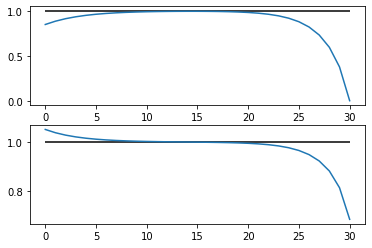

In [35]:
fig, ax = plt.subplots(2,1)
ax[0].plot(kp)
ax[1].plot(h)
ax[0].hlines(kss, 0, T)
ax[1].hlines(hss, 0, T)

Rather than plotting all periods, let's just focus on the first 15 periods, to verify convergence to the steady state:

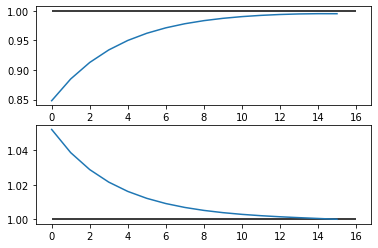

In [36]:
T_disp = 16
fig, ax = plt.subplots(2,1)
ax[0].plot(kp[:T_disp])
ax[1].plot(h[:T_disp])
ax[0].hlines(kss, 0, T_disp)
ax[1].hlines(hss, 0, T_disp)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'constr'></a>

### Constrained Optimization

Solving constrained optimization problems numerically is a highly complex topic and could very well fill a whole course by itself. Since we cannot do this here, at this point, we are going to focus on how to execute constrained optimization in SciPy rather than going in the underlying math. 

Let's start with a generic example: 

\begin{equation}
    \max_{x_1, x_2}  5 \log(x_1) - x_2^2
\end{equation}

s.t.

\begin{equation}
    x_1 = 2x_2
\end{equation}
and $x_2 \ge 1$.

That is, we have a maximization problem over two variables, one of which is bounded below, subject to a constraint. 

The basic syntax used above in the **minimize** function will be the same; however, we have two more arguments to provide, one for the **bounds** and one for **constraints**. Moreover, we will use a different method:

**scipy.optimize.minimize(fun, x0, method='SLSQP', bounds = bnds, constraints = constr, ...)**

Bounds have to be specified as a list of tuples, where each tuple corresponds on one variable, e.g. here **(1, None)** for $x_2$. If a variables is not bounded below or above, we can use **None** (or alternatively, large numbers in absolute value). 

In [37]:
## set bounds
bnds = [(None, None), (1, None)]
# bnds = [(-1e+8, 1e+8), (1, 1e+8)]

Constraints are defined as lists of dictionaries, that is, one dictionary per "group" of constraints. Each dictionary contains the **'type'** of the dictionary, which can be **'eq'** for equality or **'ineq'** for inequality constraints.

Moreover, they contain a function that captures the constraint, i.e. takes the decision vector x as input and returns the residual that must be zero if the constraint holds with equality. Here, I use a **lambda** function.

In [38]:
## define equality constraint
constr = [{'type': 'eq', 'fun': lambda x: x[0] - 2 * x[1]}]

Finally, we define the objective function, again using the **lambda** notation. Again, note that while we are maximizing the objective, SciPy's routine is for minimization, and hence we put a negative sign in front of the objective.

In [39]:
## define objective function
obj = lambda x: - ( 5 * np.log(x[0]) - x[1]**2 )

We can then run the minimization algorithm. With respect to the method, we choose "Sequential Least Squares Programming" (**SLSQP**). Again, we will not go into the math behind it. For most problems whose scale is not too large, it works well, given that you use a reasonable initial guess.

In [40]:
scipy.optimize.minimize(obj, (2,2),  method ='SLSQP', constraints = constr, bounds = bnds)

     fun: -3.256462732478156
     jac: array([-1.58054602,  3.16346362])
 message: 'Optimization terminated successfully.'
    nfev: 17
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([3.16227393, 1.58113696])

As a second example, let's again use the neoclassical growth model. However, compared to the previous section, we slightly modify the way to set it up, in order to include bounds on variables and constraints. 

Start by again defining the objective function. Note two changes to above: we include consumption **(c)** as part of the decision vector x, which shows up directly in the utility function. Moreover, we do not employ the trick used above where variables are in logs in order to exclude negative values.

In [41]:
def objective_alt(x, prm, T):
    """
    Implements the objective function of the NGM (lifetime utility)
    """    
    ## define kp, h and c
    kp = x[:T+1] 
    h = x[T+1: 2*(T+1)] 
    c = x[2*(T+1): 3*(T+1)] 
    ## define k as a vector containing the initial capital stock k0 and the first T elements of kp
    k = np.insert(kp[:T], 0, k0)
    
    return - ( prm['beta']**(np.array(range(T+1))) @ u( c, h, prm))

Next, define a function **resource_con** that captures the resource constraint: it also takes **x** an argument, and returns the difference between the endowment of the economy (production plus undepreciated capital) and what it is used for (consumption and new capital).

In [42]:
def resource_con(x):
    '''
    Implements the resource constraints of the NGM
    '''
    ## define kp, h and c
    kp = x[:T+1] 
    h = x[T+1: 2*(T+1)] 
    c = x[2*(T+1): 3*(T+1)] 
    ## define k as a vector containing the initial capital stock k0 and the first T elements of kp
    k = np.insert(kp[:T], 0, k0)
    
    return cobb_douglas(k, h, prm) + (1 - delta) * k - kp - c

As before, we use the steady state values as initial guesses (**x0**). In addition, we have to specify the bounds on the variables and the constraints. 

In [43]:
## number of periods
T = 30
## set initial guess    
x0 = np.concatenate([kss  * np.ones(T+1), hss  * np.ones(T+1), 1.3 * np.ones(T+1)])

All variables here have zero as the lower bound, while they are not bounded above. Hence, we will use a small number (**1e-8**) for the lower bound, and a large number (**1e+8**) for the upper bound. 

Recall that bounds have to be specified as a list of tuples, where each tuple corresponds on one variable, e.g. here **(1e-8, 1e+8)**. Since we have $3(T+1)$ variables, the easiest is to start with a list of one element and then repeat $3(T+1)$ (or **len(x0)**) time. 

In [44]:
## set bounds
bnds = [(1e-8, 1e+8)] * len(x0)

Regarding the constraints, recall that we have one constraints per period, so $(T+1)$ constraints in total. However, they all belong to the same "group", so one dictionary is enough. For the function, it contains the **resource_con** function defined above: 

In [45]:
## set constraints
constr = [{'type': 'eq', 'fun': resource_con}]

We then solve the model using the **SLSQP** method, with the additional keywords **constraints** and **bounds**, which take the objects defined on the previous slide.

In [46]:
## solve model
res = scipy.optimize.minimize(objective_alt, x0, args=(prm, T), method = 'SLSQP', tol = 1e-10, \
                              bounds = bnds, constraints = constr, options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.78116042050243
            Iterations: 46
            Function evaluations: 4373
            Gradient evaluations: 46


We can compare the first ten values of **kp** to the result of our unconstrained optimization above. 

In [47]:
kp_alt = res.x[:T+1] 
h_alt = res.x[T+1: 2*(T+1)] 
c_alt = res.x[2*(T+1): 3*(T+1)] 
## compare with result from unconstrained optimization
print(kp[:10])
print(kp_alt[:10])

[0.84821861 0.88492844 0.91281517 0.93396849 0.94999713 0.96213122
 0.97130731 0.97823546 0.98345267 0.98736181]
[0.84821881 0.88492873 0.91281567 0.93396936 0.94999797 0.96213198
 0.9713075  0.97823621 0.98345469 0.98736503]


--------------------------------------------------------------------------------------------------------------------------------
<a id = 'Nelder-Mead'></a>

## Appendix

### Nelder-Mead (Simplex)

Compare http://www.benfrederickson.com/numerical-optimization/ for a visualization.

Similar to golden search in the univariate case, use the Nelder-Mead algorithm only in cases where a single optimization is performed and evaluating the function and its derivatives is costly. Nelder-Mead is slow and unreliable, in particular for problems with more than two dimensions. In those cases, we are better off with using a variant of line search.

### Rosenbrock function

The *Rosenbrock function* (also called *Rosenbrock's banana function*) is often used to test the performance of optimization algorithms. In its simplest form with two variables, it looks like the following:

\begin{equation}
    f(x, y) = (a - x)^2 + b (y - x^2)^2
\end{equation}

Its global minimum is at $(a, a^2)$. Below, we set $a = 1$ and $b = 100$.

In [48]:
def banana(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

Plotting the banana function with a contour plot shows the "Rosenbrock valley" that contains the smallest function values, including the minimum:

In [49]:
x = np.linspace(-0.5, 1.5, 50)
y = np.linspace(-0.5, 1.5, 50)
xx, yy = np.meshgrid(x, y)
z = banana(xx, yy)

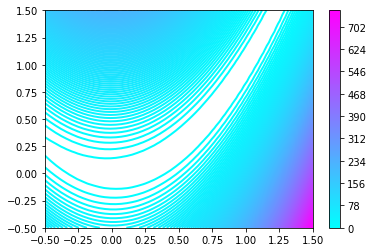

In [50]:
## plot contour
fig, ax = plt.subplots()
CP = ax.contour(x, y, z, 300,  linewidths=2, cmap='cool')
fig.colorbar(CP)

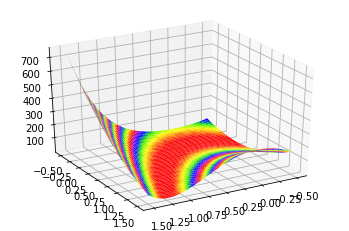

In [51]:
## 3-D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, cmap = 'prism')
ax.view_init(30, 60)

Scipy has an implementation of the Rosenbrock function, including its gradient and Hessian, as **scipy.optimize.rosen**, **scipy.optimize.rosen_der** and **scipy.optimize.rosen_hess**, respectively. 

In order to solve it with Nelder-Mead, we can use Scipy's **minimize** function, which is a "wrapper" around several different methods (some of them also for constrained optimization). Compare the documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html.

The default arguments to be given to **minimize** are the name of the function, an initial guess and the name of the method.

In [52]:
scipy.optimize.minimize(scipy.optimize.rosen, [1.5, 2], method = 'Nelder-Mead')

 final_simplex: (array([[0.99998287, 0.99996782],
       [1.00002868, 1.00005929],
       [0.99996631, 0.99992986]]), array([0., 0., 0.]))
           fun: 7.235225658704654e-10
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 49
        status: 0
       success: True
             x: array([0.99998287, 0.99996782])

More generally, Rosenbrock's function can be defined for $N \ge 2$ variables:

\begin{equation}
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N
\end{equation}

When minimizing the function, we can indicate the dimension of $\mathbf{x}$ by the length of the array serving as the initial guess: 

In [53]:
scipy.optimize.minimize(scipy.optimize.rosen, [1.5, 2, 2, 2, 2], method = 'Nelder-Mead')

 final_simplex: (array([[1.00000342, 1.00000518, 1.00001268, 1.0000237 , 1.00004644],
       [1.00000518, 1.00001424, 1.00002928, 1.00005383, 1.00010782],
       [0.99999397, 0.99999598, 0.9999898 , 0.9999779 , 0.99995271],
       [1.00000253, 1.00001166, 1.00002235, 1.0000485 , 1.00010125],
       [1.00000527, 1.00000843, 1.00001001, 1.00001619, 1.00003999],
       [1.00000403, 1.000006  , 1.00000274, 1.00000851, 1.00001169]]), array([0.        , 0.00000001, 0.00000001, 0.00000001, 0.00000001,
       0.00000001]))
           fun: 1.939389319501672e-09
       message: 'Optimization terminated successfully.'
          nfev: 653
           nit: 407
        status: 0
       success: True
             x: array([1.00000342, 1.00000518, 1.00001268, 1.0000237 , 1.00004644])

### Newton-Raphson with Two Update Rules
<a id = 'app_newton_ls'></a>

Below, we modify **my_opt** in order to allow it to use two different update rules **step1** and **step2**, which are Newton-Raphson with and without line search, respectively. It switches once **alpha** is in the interval $(0.95, 1.05)$. 

In [54]:
def my_opt_ls(x, obj, step1, step2, kappa = 0.05, maxit = 100,  tol = 1e-8, delta = 1e-4):
    """
    Implements the iterative procedure for an optimization algorithm with line search considered below . Inputs are 
    -> x: initial guess for the minimizing vector
    -> obj: objective, defined a function of x
    -> step: a function implementing how the step from x(k) to x(k+1) is determined
    """
    dist = 1
    it = 0
    
    close = False
    while dist > tol and it < maxit:
        it += 1
        
        if not close:
            s, alpha = step1(x, obj)
            if abs(alpha - 1) < kappa:
                close = True
        else:
            s, alpha = step2(x, obj)
    
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(x))
        print(it, dist, alpha)
        x = x + s
    
    ## check for optimality
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    if np.linalg.norm(gr) > delta * (1 + abs(obj(x))):
        print('Solution does not appear an optimum!')
    
    return x           

In [55]:
x0 = np.array([1.5, 2])
x = my_opt_ls(x0, obj, newton_gs, newton)
print("Equilibrium quantities: {}".format(np.exp(x)))

1 0.9105391787633729 1.2747548640213382
2 2.362582303763257 3.0461807640014253
3 1.609340623776027 1.725523324583857
4 2.124523433441326 2.1809703304147128
5 1.9059313214613125 1.921853961306824
6 2.036123557608348 2.04194554006139
7 1.9779101404477863 1.979769391021929
8 2.009663907480269 2.010297898472744
9 1.994687845121643 1.9948969623953032
10 2.0024917467017707 2.0025623377185453
11 1.9986983486003345 1.9987217350494795
12 2.000631828835756 2.0006396987711788
13 1.9996768112242 1.999679877708299
14 2.0001597920789203 2.0001607509958896
15 1.999918890595571 1.9999191783927825
16 2.000041223064077 2.0000415097437374
17 1.9999795868170973 1.9999797141624165
18 2.000009891484794 2.0000100928804554
19 1.999995038032218 1.9999952323198549
20 2.000001855743957 2.0000018569283786
21 1.999998990846409 1.9999991819759821
22 2.000001046711774 2.0000012375783394
23 1.9999991505941919 1.9999992460054503
24 1.999999926097513 2.0000001168469916
25 1.9999993805917389 1.9999995713314171
26 2.0000

C:\Users\Schmitt\Continuum\anaconda3\envs\cme\lib\site-packages\ipykernel_launcher.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=7.10196e-17): result may not be accurate.
  if __name__ == '__main__':
C:\Users\Schmitt\Continuum\anaconda3\envs\cme\lib\site-packages\ipykernel_launcher.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=7.89102e-18): result may not be accurate.
  if __name__ == '__main__':
C:\Users\Schmitt\Continuum\anaconda3\envs\cme\lib\site-packages\ipykernel_launcher.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=8.76782e-19): result may not be accurate.
  if __name__ == '__main__':
C:\Users\Schmitt\Continuum\anaconda3\envs\cme\lib\site-packages\ipykernel_launcher.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=9.74201e-20): result may not be accurate.
  if __name__ == '__main__':
C:\Users\Schmitt\Continuum\anaconda3\envs\cme\lib\site-packages\ipykernel_launcher.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=1.08245e-20): result may not be accurate.
  if

As we can see, combining the two methods reduces the number of iterations. However, it should be noted that this not always the case; compare for example Rosenbrock's function.

In [56]:
x0 = np.array([1.5, 2, 2, 2, 2])
x = my_opt_ls(x0, scipy.optimize.rosen, newton_gs, newton, kappa = 0.15)
print("Solution: {}".format(x))

1 0.5909550630434172 1.2256548267631269
2 0.09654720711727843 1.1175674258660662
3 0.06384469819367368 1
4 0.24392523432624152 1
5 0.009653664785840413 1
6 0.41357109501535233 1
7 0.10028691799695104 1
8 0.03798947567439169 1
9 0.0008305940985397821 1
10 0.0006248830903869588 1
11 1.7148837578572872e-07 1
12 3.555012649912429e-11 1
Solution: [0.9999992  0.99999841 0.99999684 0.99999368 0.99998736]


### Solving the NGM with a continuation value

Here, we re-solve the NGM, now with a continuation value to capture the infinite sum in the objective. The assumption is that in period $T$ (at the latest), the economy has reached a steady state, and hence $h_{ss} = h_{T}$ etc. Hence, starting in period $T+1$, the decision variables always take their steady state values. Thus, 

\begin{equation}
    \sum^\infty_{t = T+1} \beta^t u(A k_{ss}^\alpha h_{ss}^{1-\alpha} + (1 - \delta) k_{ss} - k_{ss}, h_{ss}) = \frac{\beta^{T+1}}{1 - \beta} u(A k_{ss}^\alpha h_{ss}^{1-\alpha} - \delta k_{ss}, h_{ss})
\end{equation}

In other words, the infinite sum above is approximated in the following way:

\begin{equation}
\begin{split}
    \sum^\infty_{t = 0} \beta^t u(c_t, h_t) = \sum^{T}_{t = 0} &\beta^t u(A k_t^\alpha h_t^{1-\alpha} + (1 - \delta) k_t -k_{t+1}, h_t) \\
    &+ \frac{\beta^{T+1}}{1 - \beta} u(A k_{T}^\alpha h_{T}^{1-\alpha}  - \delta k_{T}, h_{T})
\end{split}    
\end{equation}

This requires a small change to the objective function above:

In [57]:
def objective_cv(x, prm, T):
    """
    Implements the objective function of the NGM (lifetime utility)
    """
    ## define kp and h
    kp = np.exp( x[:T+1] )
    h = np.exp( x[T+1:] )
    ## define k as a vector containing the initial capital stock k0 and the first T elements of kp
    k = np.insert(kp[:T], 0, k0)
    
    ## continuation value
    CV = (prm['beta']**(T+1)/(1 - prm['beta'])) *  u( cobb_douglas(kp[-1], h[-1], prm) - prm['delta'] * kp[-1], h[-1], prm)
    
    return - ( prm['beta']**(np.array(range(T+1))) @ u( cobb_douglas(k, h, prm) + (1 - prm['delta']) * k - kp, h, prm)\
              + CV)